In [ ]:
!pip install bayesian-optimization

In [1]:
import time
import sys
import numpy      as np
import pandas     as pd
import matplotlib.pyplot as plt
import seaborn    as sns
from   zipfile    import ZipFile
from   datetime   import datetime
import random
import re
import os
import pickle
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
#sklearn improts

from sklearn.metrics         import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics         import precision_score, recall_score, f1_score
from sklearn.preprocessing   import StandardScaler, Normalizer
from xgboost.sklearn         import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score
from sklearn.impute          import SimpleImputer

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics         import accuracy_score, make_scorer, roc_auc_score, log_loss
import time
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score


from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline     import Pipeline
from sklearn.metrics      import accuracy_score
from sklearn.ensemble     import StackingClassifier

In [3]:
!kaggle competitions download -c icr-identify-age-related-conditions

  0% 0.00/150k [00:00<?, ?B/s]
100% 150k/150k [00:00<00:00, 20.1MB/s]


In [4]:
def open_data():
  zip_file      = 'icr-identify-age-related-conditions.zip'
  with ZipFile(zip_file) as zip:

    with zip.open(zip.namelist()[0]) as f:
      greeks             = pd.read_csv(f)
    with zip.open(zip.namelist()[1]) as f:
      sample_submission  = pd.read_csv(f)
    with zip.open(zip.namelist()[2]) as f:
      test               = pd.read_csv(f)
    with zip.open(zip.namelist()[3]) as f:
      train              = pd.read_csv(f)

    return greeks, sample_submission, test, train

greeks, sample_submission, test, train = open_data()

In [10]:
train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.910227,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,12.029366,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,8.026928,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622


In [8]:
sample_submission

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


In [7]:
greeks

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020
...,...,...,...,...,...,...
612,fd3dafe738fd,A,B,M,B,9/13/2020
613,fd895603f071,A,B,M,B,9/8/2020
614,fd8ef6377f76,A,C,M,B,7/24/2019
615,fe1942975e40,A,C,M,B,1/31/2019


\

In [5]:
def clean_data(train):
  train_id     = train['Id']
  train        = train.drop(columns = ['Id'])
  target_class = train['Class']
  train        = train.drop(columns = ['Class'])

  return train, target_class

train, target_class = clean_data(train)

**Add Categorized Alpha**
1. 0 Indicates No Diagnosis
2. 1 Indicates An Age Related Diagnosis

In [6]:
def process_data(train, preprocess_type = 'Normalize', imputation_method = 'mean'):
  '''
  Get Fields that are not str type

  Parameters:
  - train

  Returns:
  - None

  '''

  # Iterate all columns and rows

  categorical        = train.select_dtypes(include = ['object'])
  EJ_labels          = pd.factorize(train['EJ'])[1]
  train['EJ']        = pd.factorize(train['EJ'])[0]

  imputer            = SimpleImputer(strategy = imputation_method)


  train              = pd.DataFrame(imputer.fit_transform(train), columns = train.columns)

  # print(train)


  #
  if preprocess_type == 'StandardScaler':
    scaler             = StandardScaler()
    train_scaled       = scaler.fit_transform(train)
    train_scaled       = pd.DataFrame(train_scaled, columns = train.columns)

  if preprocess_type == 'Normalize':
    normalizer         = Normalizer()
    train_scaled       = normalizer.fit_transform(train)
    train_scaled       = pd.DataFrame(train_scaled, columns = train.columns)


  return train_scaled



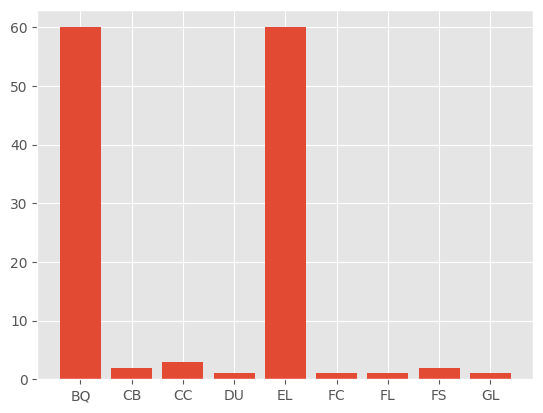

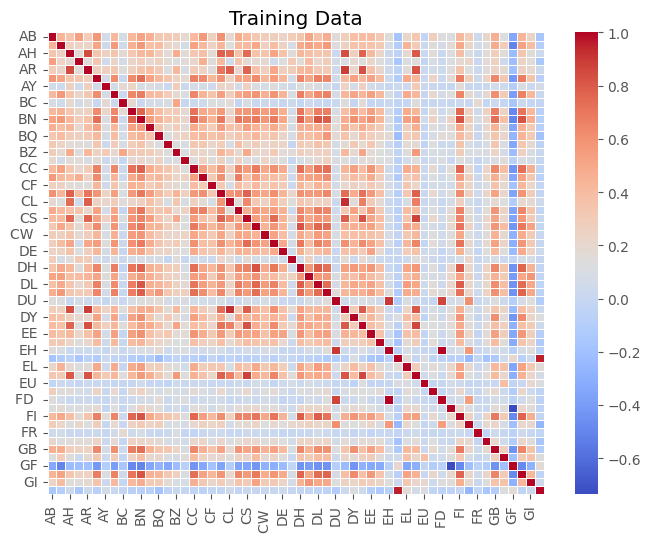

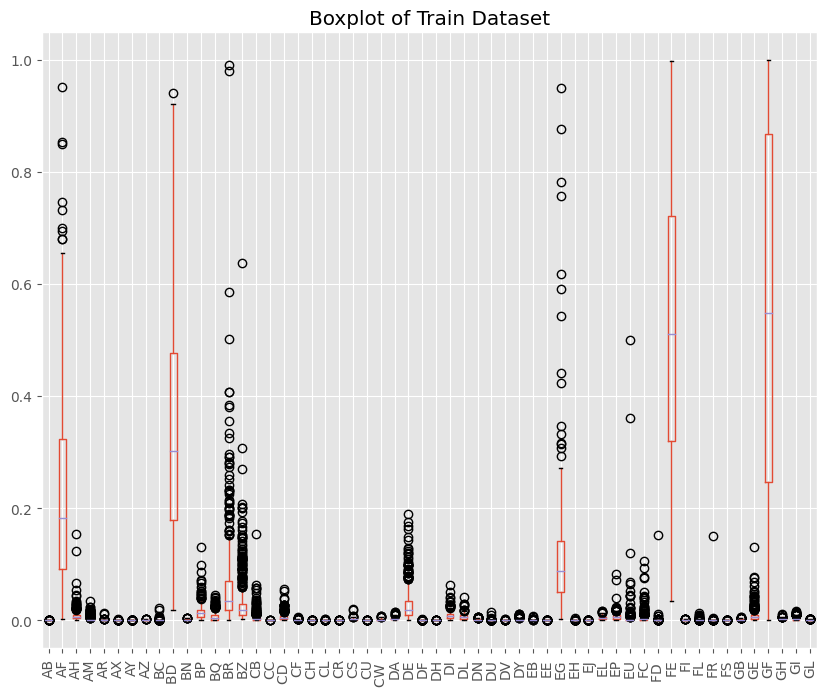

In [51]:
def EDA(greeks, train, print_summaries = False):
    '''

    Parameters:
    - greeks:
    - train:
    - print_summaries:

    Returns:
    - na_values
    - train:

    '''

    # Count of missing values
    na_values = train.isna().sum()
    na_values = na_values[na_values > 0]

    plt.bar(na_values.index, na_values.values)
  # unique_greek = greeks[['Beta', 'Gamma', 'Delta']].nunique()
  # Processing Data
  # na_values    = train.isna().sum()

    train = process_data(train, preprocess_type = 'Normalize')

    plt.style.use('ggplot')

    if print_summaries:
        # Display basic statistics
        print("Descriptive Statistics for Greeks:")
        print(greeks.describe())  # Summary statistics for numerical columns

        print("\nDescriptive Statistics for Train:")
        print(train.describe())

        # Count of unique values in specified columns
        unique_greek = greeks[['Beta', 'Gamma', 'Delta']].nunique()
        print("\nUnique values in Greek columns:")
        print(unique_greek)


    # print("\nMissing values in Train dataset:")
    # print(na_values)

    # Plotting
    # Histograms for the 'greeks' DataFrame

    # Correlation heatmap
    numerical   = train.select_dtypes(include=['int64', 'float64'])
    corr_matrix = numerical.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Training Data')
    plt.show()

    # Boxplots for the 'train' DataFrame to identify outliers
    plt.figure(figsize=(10, 8))
    train.boxplot()
    plt.title('Boxplot of Train Dataset')
    plt.xticks(rotation = 90)
    plt.show()


    return na_values, train

na_values, train = EDA(greeks, train)



**Use a Multivariate Correlation Imputer**

In [ ]:
# explicitly require this experimental feature
# from sklearn.experimental import enable_iterative_imputer # noqa
# from sklearn.ensemble     import RandomForestRegressor
# from sklearn.impute       import IterativeImputer

# imp   = IterativeImputer(estimator=RandomForestRegressor())
# train = pd.DataFrame(imp.fit_transform(train), columns = train.columns)

# Exploratory DA

1. Scales of Variable Are Different Standard Scaler

**View Mean of Scaled Data**

In [52]:
def plot_summaries(statistics, subset = None):
  '''

  Parameters:
  - statistics:
  - subset:

  Returns:
  - None:

  '''
  if subset is None:
    categories = statistics.columns
  else:
    categories = subset

  for stat in categories:
    figure   = plt.figure(figsize = (9, 6))
    plot     = sns.barplot(statistics, y = stat, x = statistics.index)
    plot.set_xticklabels(rotation = 90, labels = statistics.index)
    plot.set_title(stat)

  return


# # subset = ['mean', '50%', 'max']
# plot_summaries(statistics, subset = subset)

**The Data is skewed for a lot of variables**
1. Mean and Median are not approximately equal
2. Definitely a consideration for downstream to remove outliers

**Reset Index for Stratified K Fold Calls**

In [60]:
def split_data(x_data, y_data, test_size = 0.2):

  x1, x2, y1, y2 = train_test_split(x_data, y_data, test_size = test_size)  # PCA's make it worse
  return x1, x2, y1, y2

x_train, x_test, y_train, y_test = split_data(train, target_class)
x_test, x_val, y_test, y_val     = split_data(x_test, y_test, test_size = 0.5)

**Next Move**
1. Use Variational Autoencoder embeddings and resubmit to Competition

**Loss Function**

In [55]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics         import accuracy_score, make_scorer, roc_auc_score, log_loss
import time
from sklearn.utils import class_weight


# output of function needs to minimzied
# for a classification problem, were minimizing the accuracy
# so in theory, it's really just having a metric that calculates the accuracy
# then that accuracy is being maximzied in a bayesian fassion
def bayes_opt(n_estimators, subsample, learning_rate, max_depth, colsample_bytree, eta):

  folds     = 5
  skf       = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

  params_gbm                     = {}
  params_gbm['learning_rate']    = learning_rate
  params_gbm['n_estimators']     = int(n_estimators)
  # params_gbm['reg_lambda']       = reg_lambda
  # params_gbm['reg_alpha']        = reg_alpha
  # params_gbm['gamma']            = round(gamma)
  params_gbm['subsample']        = subsample
  params_gbm['max_depth']        = int(max_depth)
  params_gbm['colsample_bytree'] = colsample_bytree
  params_gbm['eta']              = eta

  weights      = class_weight.compute_sample_weight('balanced', y_train)

  # K-Fold Cross Validation
  scores       = []
  for fold, (train_idx, val_idx) in enumerate(skf.split(x_train, y_train)):

    x_train_fold, y_train_fold = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_val, y_val = x_train.iloc[val_idx], y_train.iloc[val_idx]
    watchlist = [(x_train_fold, y_train_fold), (x_val, y_val)]

    scorer     = make_scorer(log_loss)

    xgb_model  = XGBClassifier(**params_gbm,
                               objective = 'binary:logistic',
                               eval_metric = 'logloss')

    xgb_model.fit(x_train_fold, y_train_fold)

    val_preds  = xgb_model.predict_proba(x_val)
    score      = log_loss(y_val, val_preds)
    scores.append(score)



  scores = np.average(scores)

  # maximize 1 - scores (minimize log_loss)
  # function maximizes function so we subtract it from 1 to minimize it
  return 1 - scores



run_optimizations = False
if run_optimizations:
    pbounds = {'n_estimators': (50, 200),
              'subsample': (0.5, 1.0),
              'learning_rate':(0.01, 3),
              'max_depth': (3, 10),
              'colsample_bytree': (0.5, 1),
              'eta': (0.2, 0.4)
              }

    optimizer   = BayesianOptimization(
        f       = bayes_opt,
        pbounds = pbounds,
        verbose = 2
    )

    optimizations = optimizer.maximize(
    init_points   = 6,
    n_iter        = 150)


In [75]:
def fit_xgb(optimizer, x_train, y_train, x_test, y_test):

  best_params = optimizer.max['params']
  best_params['n_estimators'] = round(best_params['n_estimators'])
  best_params['max_depth']    = round(best_params['max_depth'])

  xgb_model       = XGBClassifier(**best_params)
  xgb_model       = xgb_model.fit(x_train, y_train)
  predictions     = xgb_model.predict(x_test)


  # Calculate precision, recall, and F1 score

  precision = precision_score(y_test, predictions)
  recall    = recall_score(y_test, predictions)
  f1        = f1_score(y_test, predictions)
  roc_score = roc_auc_score(y_test, predictions)

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print('ROC_AUC:', roc_score)


  return xgb_model

xgb_model = fit_xgb(optimizer, x_train, y_train, x_test, y_test)

Precision: 0.75
Recall: 0.6666666666666666
F1 Score: 0.7058823529411765
ROC_AUC: 0.8144654088050314


In [ ]:
test_data       = test.drop(columns = ['Id'])
test_data['EJ'] = pd.factorize(test_data['EJ'])[0]

submission                         = sample_submission.copy()
submission[['class_0', 'class_1']] = xgb_model.predict_proba(test_data)
submission.to_csv('submission.csv', index=False)

# Ensemble Modeling Exploration

**Machine Learning Model**
1. Plan is to remove decisiontree classifier because it's too simple (one decision tree makes all decisions)
2. Create a nueral network as the third model

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.linear_model   import LinearRegression, SGDClassifier

class EnsembleLearning:

  def __init__(self):

    #---------- Model Initialization ----------
    # xgb_model                   = XGBClassifier(n_estimators = 300, max_depth = 7, eta = 0.2784,
    #                               colsample_bytree = 0.8361, learning_rate = 0.03398,
    #                               subsample = 0.8534, eval_metric = 'logloss')

    # xgb_model                   = XGBClassifier(n_estimators = 162, max_depth = 3, eta = 0.3398,
    #                                             colsample_bytree = 0.6864, learning_rate = 0.1082, subsample = 0.5206,
    #                                             eval_metric ='logloss')
    rf_model                    = RandomForestClassifier(n_estimators = 157, max_depth = 10, min_samples_split = 2)
    nueral_network              = MLPClassifier(activation = 'relu',
                                                hidden_layer_sizes = (64,))
    self.weak_learners          = [('DecisionTree', nueral_network),
                                  ('RandomForest', rf_model)]
                                  # ,
                                  # ('XGBModel', xgb_model)]

    self.final_learner          = LogisticRegression()
    # self.final_learner            = SGDClassifier()
    # self.final_learner          = KNeighborsClassifier()

    self.folds                  = 5
    self.skf                    = StratifiedKFold(n_splits=self.folds, shuffle = True, random_state = 1001)
    self.weights                = class_weight.compute_sample_weight('balanced', y_train)

    self.scores                 = []
    self.validation_predictions = {} # new training dataset
    self.test_predictions       = {} # new test dataset



    #------------- Function Calls ----------
    self.train_model()

  # Create First Layer for Ensemble Learning
  def train_model(self):

    self.individual_scores                 = {}
    self.individual_scores['DecisionTree'] = []
    self.individual_scores['RandomForest'] = []
    self.individual_scores['XGBModel']     = []
    self.train_meta_model                  = None
    self.test_meta_model                   = None

    self.stacked_model      = StackingClassifier(estimators = self.weak_learners,
                                            final_estimator = self.final_learner)

    # K Fold Cross Val and Normal Training To Create 2nd Layer Training
    for fold, (train_idx, val_idx) in enumerate(self.skf.split(x_train, y_train)):
      x_train_fold, y_train_fold = x_train.iloc[train_idx], y_train.iloc[train_idx]
      x_val, y_val   = x_train.iloc[val_idx], y_train.iloc[val_idx]
      watchlist      = [(x_train_fold, y_train_fold), (x_val, y_val)]

      self.stacked_model.fit(x_train_fold, y_train_fold)
      y_pred         = self.stacked_model.predict_proba(x_val)
      score          = log_loss(y_val, y_pred)
      self.scores.append(score)

    self.scores       = np.average(self.scores)

    print(self.scores)
    return self.scores


Ensemble_model = EnsembleLearning()

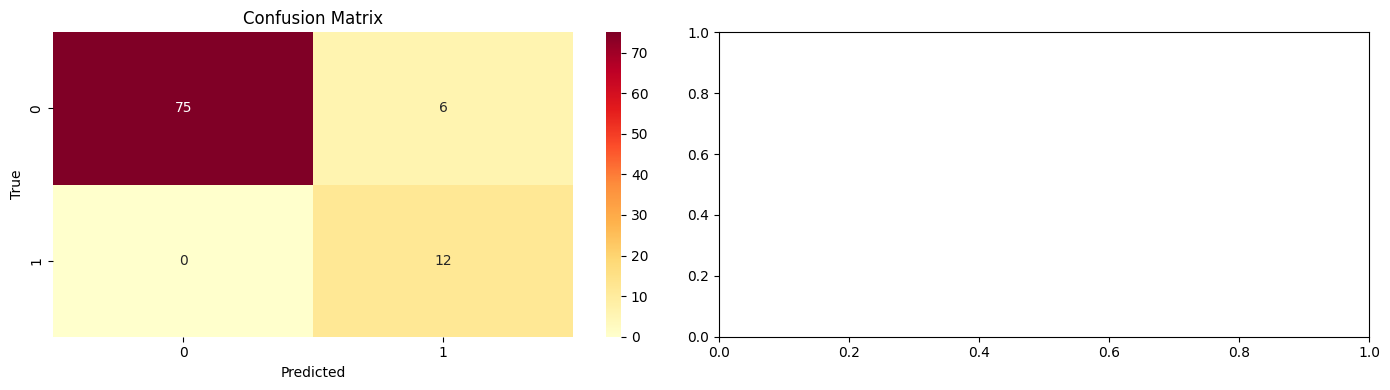

In [ ]:
# Confusion Matrix for the last fold
model = Ensemble_model.stacked_model
cm    = confusion_matrix(model.predict(x_test), y_test)

# Feature Importance for the last model
# feature_imp = pd.DataFrame({'Value':xgb_model.feature_importances_, 'Feature':x_train.columns})
# feature_imp = feature_imp.sort_values(by="Value", ascending=False)
# feature_imp_top20 = feature_imp.iloc[:20]

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Subplot 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='YlOrRd')
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

# Subplot 2: Feature Importance
# sns.barplot(x="Value", y="Feature", data=feature_imp_top20, ax=ax[1], palette='YlOrRd_r')
# ax[1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

In [ ]:
submission                           = sample_submission.copy()
submission[['class_0', 'class_1']]   = Ensemble_model.stacked_model.predict_proba(test_data)
submission.to_csv('submission.csv', index=False)